In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

# Image Classification

## From Dogs and Cats to Pet Breeds

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [6]:
(path/"images").ls()

(#7393) [Path('images/miniature_pinscher_199.jpg'),Path('images/newfoundland_183.jpg'),Path('images/pomeranian_90.jpg'),Path('images/pomeranian_102.jpg'),Path('images/japanese_chin_74.jpg'),Path('images/yorkshire_terrier_45.jpg'),Path('images/chihuahua_34.jpg'),Path('images/american_pit_bull_terrier_150.jpg'),Path('images/wheaten_terrier_160.jpg'),Path('images/staffordshire_bull_terrier_91.jpg')...]

In [7]:
fname = (path/"images").ls()[0]
fname

Path('images/miniature_pinscher_199.jpg')

In [8]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['miniature_pinscher']

In [9]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42), #split randomly
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'), #getting labels
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)) #augmentation on data

dls = pets.dataloaders(path/"images")

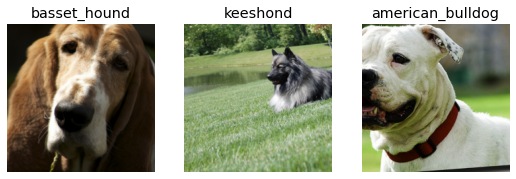

In [10]:
dls.show_batch(nrows = 1, ncols=3)

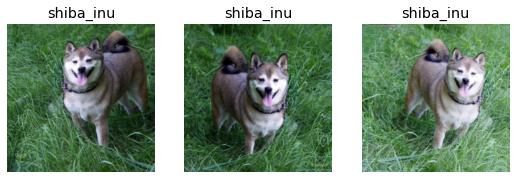

In [11]:
dls.show_batch(nrows=1, ncols = 3, unique = True)

## Lets test the model with what we have currently

In [12]:
learn = cnn_learner(dls, resnet18, metrics=accuracy) #Notice we didn't choose a loss, FastAI picks one for us 
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.532583,0.412520,0.868065,01:20
1,0.705810,0.353400,0.887010,01:07


In [13]:
learn.loss_func #fastAI chose CrossEntropyLoss as the loss func

FlattenedLoss of CrossEntropyLoss()

## Presizing

In [ ]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

## Cross-Entropy Loss

### Viewing Activations and Labels

In [15]:
x,y = dls.one_batch()

In [16]:
y #values refer to vocab list

TensorCategory([18, 19, 20, 23, 24, 35, 27, 27, 32, 16,  0,  9, 21,  0,  2, 12, 26, 10, 24, 20, 32, 27, 18, 28,  8, 18, 23, 21, 30, 29,  9, 26, 25, 29, 14, 11, 34,  7, 36,  4,  9,  6, 23, 20, 17, 14, 25, 19,
        23,  8, 18,  2, 11,  7,  9, 19, 19, 31,  1, 29,  1, 31,  7, 33], device='cuda:0')

In [17]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [18]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds

TensorImage([[2.1285e-01, 4.7995e-02, 1.1221e-03,  ..., 1.4506e-03, 9.0126e-03, 2.4594e-02],
        [6.9040e-06, 4.3596e-03, 8.7159e-06,  ..., 3.3018e-05, 2.8775e-05, 2.5054e-05],
        [2.1535e-12, 2.2470e-11, 5.4650e-12,  ..., 2.8323e-10, 1.6942e-10, 4.7921e-11],
        ...,
        [1.0889e-07, 3.3818e-07, 1.8115e-05,  ..., 4.5040e-07, 3.6186e-06, 5.4762e-08],
        [2.5651e-04, 5.6865e-05, 4.7429e-02,  ..., 1.0788e-05, 2.0495e-04, 3.3897e-06],
        [1.6846e-05, 3.8460e-06, 1.8923e-06,  ..., 1.2548e-06, 2.0216e-06, 2.9412e-07]])

In [19]:
len(preds[0]),preds[0].sum() #37 pred and all add up to 1 

#How did we manage to make all the pred add up to 1? Softmax!

(37, TensorImage(1.0000))

### Softmax 
#### Shows why softmax is better than sigmoid when dealing with more classes

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


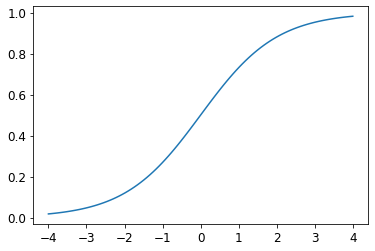

In [20]:
plot_function(torch.sigmoid, min=-4,max=4)

In [21]:
#hide
torch.random.manual_seed(42);

In [22]:
acts = torch.randn((6,2))*2 #Getting preds
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [23]:
acts.sigmoid() #using sigmoid to squish pred (Notice that although the values are between 0-1, they dont add up to 1)

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

### Can fix by switching to softmax

In [24]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts #notice that now they add up to 1

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Unique indexing technique

In [25]:
targ = tensor([0,1,0,1,1,0])

In [26]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [27]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [28]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [29]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [30]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Taking the Log

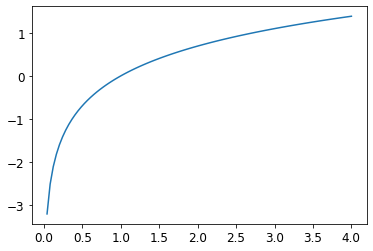

In [31]:
plot_function(torch.log, min=0,max=4)

In [32]:
loss_func = nn.CrossEntropyLoss()

In [33]:
loss_func(acts, targ)

tensor(1.8045)

In [34]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [35]:
nn.CrossEntropyLoss(reduction='none')(acts, targ) #Shows individual loses before taking the mean

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

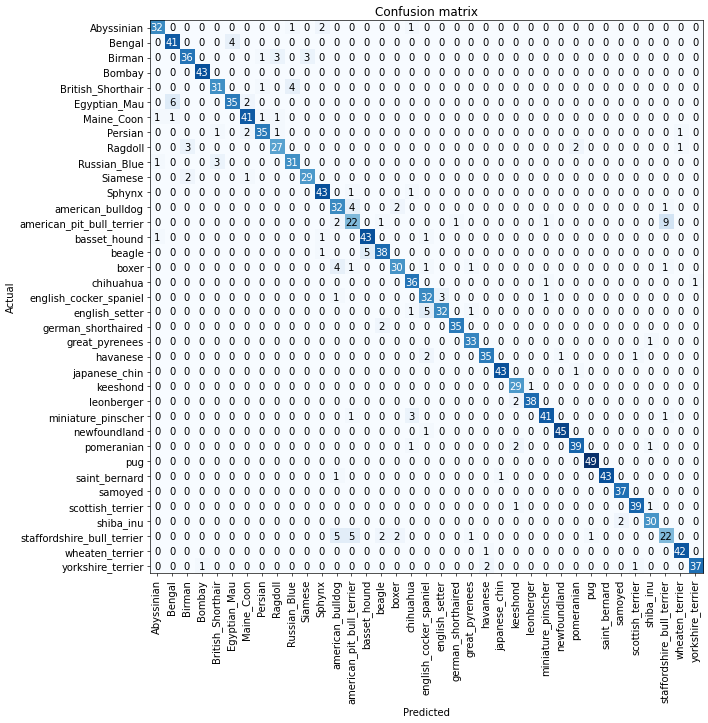

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [44]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('Egyptian_Mau', 'Bengal', 6),
 ('beagle', 'basset_hound', 5),
 ('english_setter', 'english_cocker_spaniel', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5)]

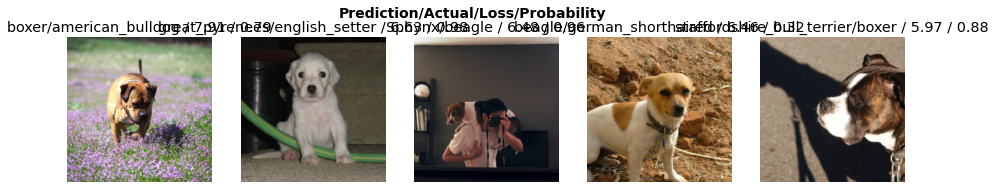

In [45]:
interp.plot_top_losses(5, nrows=1)

## Improving Our Model

### The Learning Rate Finder

In [36]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

#Current err is 40% - Very bad

epoch,train_loss,valid_loss,error_rate,time
0,2.820359,3.461341,0.359269,01:07


epoch,train_loss,valid_loss,error_rate,time
0,2.837471,1.268851,0.390392,01:24


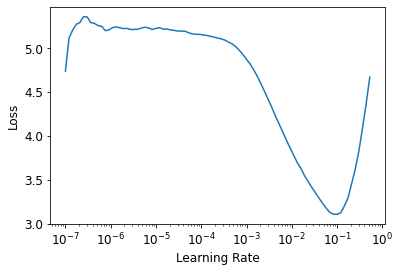

In [37]:
learn = cnn_learner(dls, resnet34, metrics=error_rate) 
lr_min,lr_steep = learn.lr_find() #Finding best lr

In [38]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 3.63e-03


In [43]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3) #pick something inbetween

#error rate dropped down to 7%

epoch,train_loss,valid_loss,error_rate,time
0,1.285344,0.377785,0.117050,01:40


epoch,train_loss,valid_loss,error_rate,time
0,0.522819,0.429013,0.128552,02:12
1,0.318475,0.252019,0.075778,02:12


### Unfreezing and Transfer Learning

## fine_tune()
```python
learn.fine_tune??
```


>freeze() - Freezes the model first  
>fit_one_cycle(1) - Runs 1 epoch to tune the final layers (Model frozen remember)   
>base_lr /= 2 - Changes the lr  
>unfreeze() - Now all parameters can be stepped  
>self.fit_one_cycle - Now we fit the model on the number of given epochs (Input)


## We will now implement fine_tune below

In [49]:
learn = cnn_learner(dls, resnet34, metrics=error_rate) #cnn_learner freezes model for us
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.134641,0.368042,0.112991,01:40
1,0.526193,0.260705,0.083897,01:40
2,0.330762,0.236595,0.075101,01:40


In [50]:
learn.unfreeze() 

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=0.00013182566908653826)

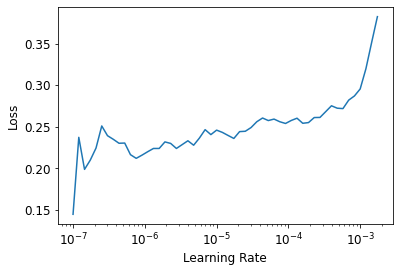

In [51]:
learn.lr_find()

In [52]:
learn.fit_one_cycle(3, lr_max=1e-5) #Update learning rate again and train some more

epoch,train_loss,valid_loss,error_rate,time
0,0.276042,0.235768,0.077131,02:12
1,0.237535,0.232880,0.071042,02:20
2,0.216734,0.229787,0.071719,02:15


### Discriminative Learning Rates

In [10]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(6, lr_max=slice(1e-6,1e-4)) #can do better using a slice

epoch,train_loss,valid_loss,error_rate,time
0,1.136157,0.331316,0.108254,01:44
1,0.526700,0.263616,0.078484,01:41
2,0.318562,0.241009,0.075778,01:41


epoch,train_loss,valid_loss,error_rate,time
0,0.239533,0.225810,0.073072,02:13
1,0.240597,0.223987,0.069689,02:13
2,0.203807,0.220246,0.064276,02:13
3,0.202546,0.215731,0.066306,02:13
4,0.188517,0.213268,0.066306,02:13
5,0.177560,0.210809,0.065629,02:13


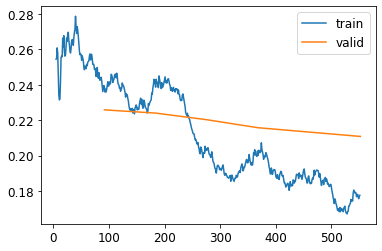

In [11]:
learn.recorder.plot_loss()

### Selecting the Number of Epochs

### Deeper Architectures

In [12]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16() #half as many bits (Half precision floating pts)
learn.fine_tune(6, freeze_epochs=3) #First 3 epochs train finals layer, next 6 train all parameters

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.426074,0.289685,0.094723,02:23
1,0.630846,0.336782,0.109608,02:23
2,0.421451,0.289481,0.083221,02:23


epoch,train_loss,valid_loss,error_rate,time
0,0.265935,0.293698,0.094046,03:13
1,0.291401,0.294177,0.081867,03:14
2,0.256584,0.271347,0.077131,03:14
3,0.164891,0.258964,0.073072,03:14
4,0.088564,0.210342,0.064953,03:14
5,0.051878,0.209877,0.063599,03:14


## Conclusion

## Questionnaire

1. **Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?**  
This proccess is actually known as presizing. Here a large image is needed because data augmentation often leads to degradation of the image. Therefore, to minize this destruction of the image quality, this technique known as presizing is used.
1. **If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.**  
1. **What are the two ways in which data is most commonly provided, for most deep learning datasets?**  
Individual files with data (Ex: Images)  
Tabular data (CSV data)
1. **Look up the documentation for `L` and try using a few of the new methods that it adds.**  
L is a custom list class by FastAI. It is designed to be a replacement for list in python.
1. **Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.**  
1. **Give two examples of ways that image transformations can degrade the quality of the data.**  
Rotating an image by leaves corner regions of the new bounds with emptiness, which will not teach the model anything.   
Many rotation and zooming operations will require interpolation, which leave a lower quality image.
1. **What method does fastai provide to view the data in a `DataLoaders`?**  
DataLoader.show_batch()
1. **What method does fastai provide to help you debug a `DataBlock`?**  
DataBlock.summary()
1. **Should you hold off on training a model until you have thoroughly cleaned your data?**  
No. It is better to create a model first and then plot_top_losses to have the model help you clean the data.
1. **What are the two pieces that are combined into cross-entropy loss in PyTorch?** 
Softmax function and Negative Log Likelihood Loss
1. **What are the two properties of activations that softmax ensures? Why is this important?**  
All values add up to 1 and amplifies small changes in the output activations. This overall makes the model more confident when classifying.
1. **When might you want your activations to not have these two properties?**  
I guess when you have more than one label possible for a class.
1. **Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).**  
1. **Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?**  
torch.where can only select between two possibilities. 
1. **What is the value of log(-2)? Why?**  
Undefined. Log is the inverse of exp, where all values are pos.
1. **What are two good rules of thumb for picking a learning rate from the learning rate finder?**  
Minimum/10  
Subjective choice based on observation
1. **What two steps does the `fine_tune` method do?**  
Freezes and trains the head for 1 epoch  
Unfreezes and trains on the input epochs
1. **In Jupyter Notebook, how do you get the source code for a method or function?**  
??
1. **What are discriminative learning rates?**  
Trick of using different learning rates for different layers of the model. Here the early layers have a lower lr and the later layers have a higher lr. 
1. **How is a Python `slice` object interpreted when passed as a learning rate to fastai?**  
First val is the initial lr, final val is the final lr, and the layers inbetween have a lr thats equal distant in the range.
1. **Why is early stopping a poor choice when using 1cycle training?**  
The training may not have time to reach lower learning rate values.
1. **What is the difference between `resnet50` and `resnet101`?**  
Number of layers
1. **What does `to_fp16` do?**  
Lowers the floating point precision numbers so you can speed up training.

### Further Research

1. **Find the paper by Leslie Smith that introduced the learning rate finder, and read it.**  
1. **See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.**  
Rather than doing this lesson, I decided to do the MNIST, for which I had an accuracy of 61%. After the LR improvement it jumped to 87%.